## Що ж ми тестували:

Група А: цим користувачам ми пропонуємо купити підписку за $4.99, щоб отримати доступ до преміум-функцій застосунку
Група В: пропонуємо ту ж підписку, але з припискою про те, що це пропозиція зі знижкою 50%

Для зручності припускаємо, що додаткові метрики не зазнали значних змін, тому аналізувати результати тесту будемо, спираючись на конверсію з інстала в платіж.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pltq
import seaborn as sns
import datetime as dt
from scipy import stats

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

pd.set_option('display.max_columns', 700)
pd.set_option('display.max_rows', 400)
pd.set_option('display.min_rows', 10)
pd.set_option('display.max_colwidth', 50)

In [7]:
df = pd.read_csv('dz/ab_test_data.csv')
df

,user_id,timestamp,test_group,conversion
0,7f6833e6-1141-4f20-b4b2-f1e31019b1fd,2023-07-04 04:40:55.848109,a,0
1,e6a6e960-d3f3-4074-a516-ba1e609b211e,2023-07-06 00:26:45.486187,b,0
2,4d3fbfa5-6847-410a-bac2-477f01d5f400,2023-07-10 20:24:33.639464,b,0
3,361457d9-a044-48f7-981c-d67dc3861679,2023-07-20 07:04:49.957013,b,0
4,285cd63d-7d03-427f-a062-1fa2dd2e77d6,2023-07-19 23:27:50.116680,b,0
...,...,...,...,...
19993,6763ae9a-515c-473e-af00-0d9c4f6a5bc7,2023-07-06 03:27:37.041104,b,0
19994,ac5600f2-4d16-4503-b115-f1a96728b6d1,2023-07-03 04:20:48.572143,a,0
19995,5a8b2630-209b-4d83-b47f-0f3d9dd568a8,2023-07-23 16:23:49.211910,b,1
19996,b572d68b-26ac-432b-9f88-83e0fdee4ca1,2023-07-03 18:26:20.880675,b,0


In [4]:
df.columns

Index(['user_id', 'timestamp', 'test_group', 'conversion'], dtype='object')

1.1 Кількість користувачів в групах A та B

In [5]:
df = df.groupby('test_group')['user_id'].nunique()
df

test_group
a    10013
b     9985
Name: user_id, dtype: int64

In [8]:
users_in_group_a = df.loc[df['test_group'] == 'a', 'user_id'].nunique()
users_in_group_b = df.loc[df['test_group'] == 'b', 'user_id'].nunique()

In [9]:
users_in_group_a

10013

In [10]:
users_in_group_b

9985

1.2 Кількість конверсій в групах A та B відповідно

In [71]:
group_a=df.loc[df['test_group'] == 'a', 'conversion'].sum()
group_a

611

In [72]:
group_b = df.loc[df['test_group'] == 'b', 'conversion'].sum()
group_b

889

1.3 Рівень конверсії в групах A та B відповідно

In [98]:
(group_a/users_in_group_a)*100

6.102067312493758

In [99]:
(group_b/users_in_group_b)*100

8.903355032548824

1.4 Дату початку та дату кінця тесту, а також тривалість тесту в днях.

In [58]:
from datetime import datetime as dt
start_test = min(df['timestamp'])
end_test = max(df['timestamp'])и
print(start_test_date)
print(end_test_date)
test_dur = (dt.strptime(end_test, "%Y-%m-%d %H:%M:%S.%f") - dt.strptime(start_test, "%Y-%m-%d %H:%M:%S.%f")).days
print(f"Start: {start_test}, End: {end_test}, duration of days: {test_dur}")

2023-07-03 01:42:34.033708
2023-07-25 01:41:19.152664
Start: 2023-07-03 01:42:34.033708, End: 2023-07-25 01:41:19.152664, duration of days: 21


Обери статистичний критерій для тестування гіпотез на свій розсуд та обрахуй значення статистики та p-value. Перевір, чи можемо ми відхили нульову гіпотезу. Не забудь уточнити, який критерій використовуєш 😉

In [17]:
from scipy.stats import ttest_ind_from_stats

In [12]:
df.groupby('test_group').describe()

conversion                                             
                count      mean       std  min  25%  50%  75%  max
test_group                                                        
a             10013.0  0.061021  0.239380  0.0  0.0  0.0  0.0  1.0
b              9985.0  0.089034  0.284806  0.0  0.0  0.0  0.0  1.0

In [21]:
statistic, pvalue = ttest_ind_from_stats(mean1=0.061021, std1=0.239380, nobs1=10013,
                     mean2=0.089034, std2=0.284806, nobs2=9985,
                    alternative = 'less')
pvalue <0.05

True

# Тест з перестановками

In [24]:
statistic, pvalue = stats.ttest_ind(a=df[df['test_group']=='a']['conversion'],
                                    b=df[df['test_group']=='b']['conversion'],
                                    alternative = 'less')
statistic

-7.5299531387344185

In [30]:
a=df[df['test_group']=='a']['conversion']
b=df[df['test_group']=='b']['conversion']

def statistic(x, y):
    return stats.ttest_ind(x, y, alternative='less').statistic

result = stats.permutation_test(data=(a, b),
statistic=statistic,
n_resamples=1000)

Побудуй візуалізацію для порівняння середніх значень у групах з 95% довірчими інтервалами


<Axes: ylabel='Count'>

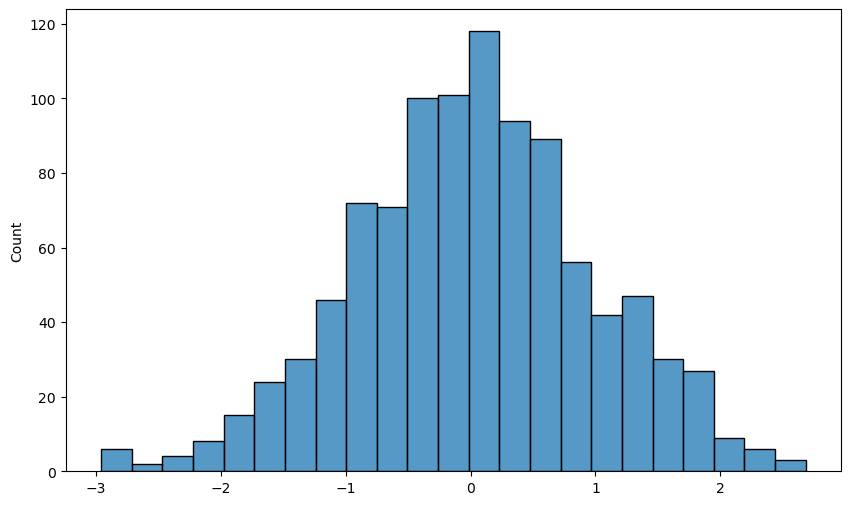

In [33]:
plt.figure(figsize=(10,6))

sns.histplot(result.null_distribution)

<Axes: xlabel='test_group', ylabel='conversion'>

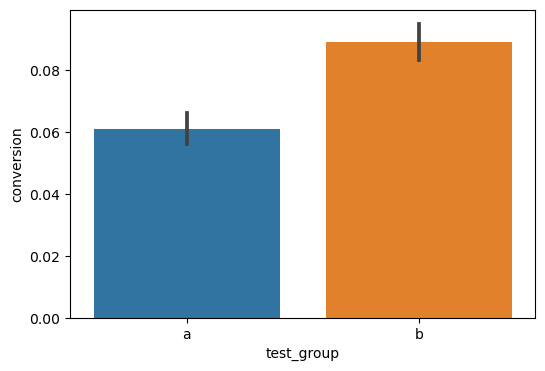

In [37]:
plt.figure(figsize=(6,4))
sns.barplot(x=df['test_group'],
            y=df['conversion'])

Графік, що відображатиме зміну конверсії в часі

Text(0, 0.5, 'Cumulative conversion Rate')

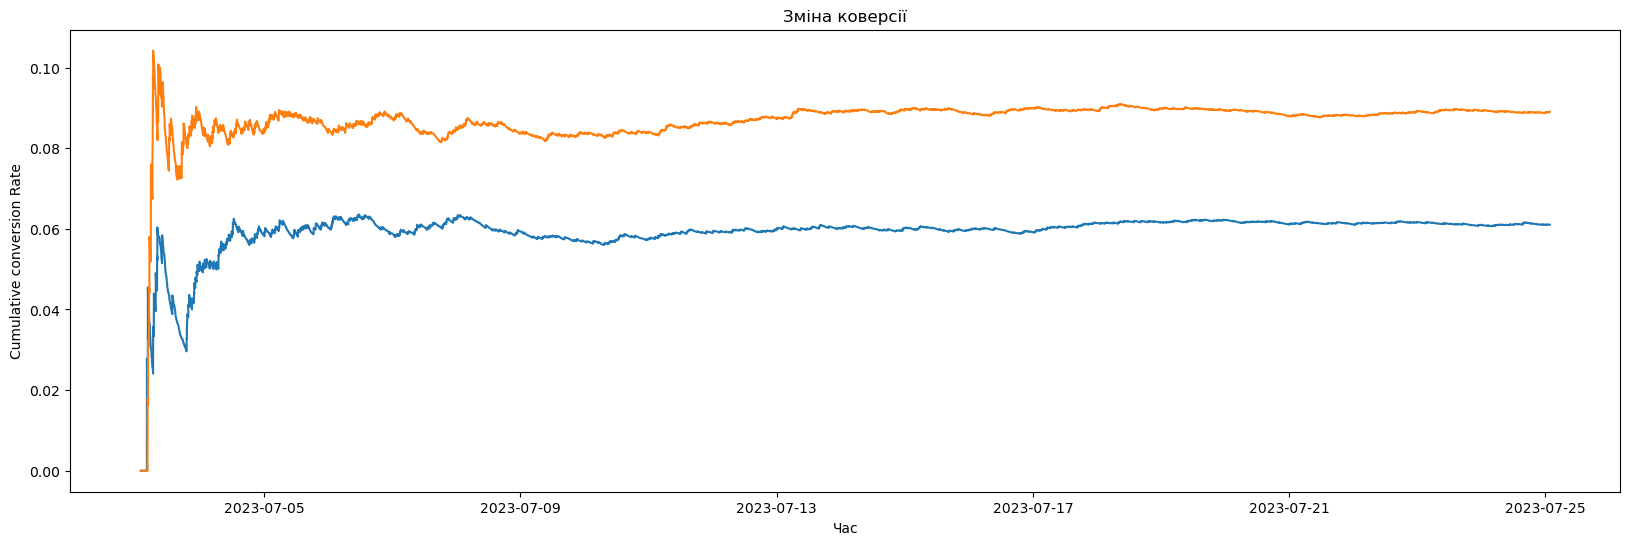

In [89]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

df.sort_values(by='timestamp', inplace=True)

df.set_index('timestamp', inplace=True)

cumul_a = df[df['test_group'] == 'a']['conversion'].expanding().mean()
cumul_b = df[df['test_group'] == 'b']['conversion'].expanding().mean()

plt.figure(figsize=(20, 6))
plt.plot(cumul_a, label='a')
plt.plot(cumul_b, label='b')
plt.title('Зміна коверсії')
plt.xlabel('Час')
plt.ylabel('Cumulative conversion Rate')